In [1]:
# Gerekli Kütüphaneleri Çağırma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# *** DOSYAYI OKUMA (Doğru Ad ve Ayırıcı ile) ***
file_name = "turkey_earthquakes(1915-2021).csv"
df = pd.read_csv(file_name, sep=';')

print("--- İlk 5 Satır ---")
print(df.head())

--- İlk 5 Satır ---
   No   Deprem Kodu Olus tarihi  Olus zamani    Enlem   Boylam  Derinlik   xM  \
0   1  2.021010e+13  2021.01.01  16:36:21.41  35.9273  27.8658      26.1  3.9   
1   2  2.020120e+13  2020.12.31  00:51:27.94  37.8435  26.7775       8.0  3.8   
2   3  2.020120e+13  2020.12.30  18:45:12.79  36.4918  28.7092       5.0  3.9   
3   4  2.020120e+13  2020.12.30  13:40:12.22  37.7960  26.4165      14.4  4.4   
4   5  2.020120e+13  2020.12.27  20:08:36.88  38.4172  39.1482       5.0  3.9   

    MD   ML   Mw   Ms   Mb Tip                                             Yer  
0  0.0  3.9  3.7  0.0  0.0  Ke                           RODOS ADASI (AKDENIZ)  
1  0.0  3.8  3.7  0.0  0.0  Ke                                      EGE DENIZI  
2  0.0  3.7  3.9  0.0  0.0  Ke                                         AKDENIZ  
3  0.0  4.4  4.3  0.0  0.0  Ke                          ONIKI ADALAR (AKDENIZ)  
4  0.0  3.7  3.9  0.0  0.0  Ke  KAVAKKOY-SIVRICE (ELAZIG) [South West  0.5 km]  



Veri temizleme tamamlandı. Son geçerli satırlar:
                          xM
Timestamp                   
2020-12-27 20:08:36.880  3.9
2020-12-30 13:40:12.220  4.4
2020-12-30 18:45:12.790  3.9
2020-12-31 00:51:27.940  3.8
2021-01-01 16:36:21.410  3.9


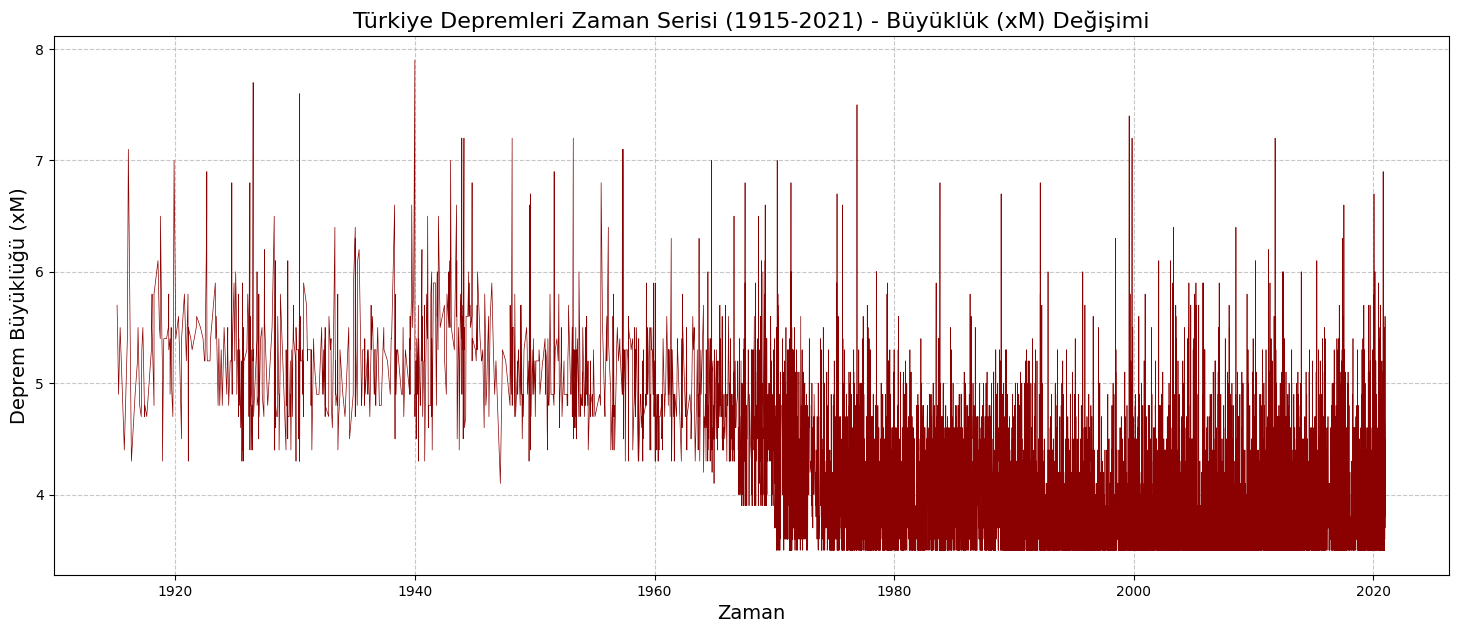

In [2]:
# Zaman Damgası (Timestamp) Oluşturma
df['Timestamp'] = pd.to_datetime(
    df['Olus tarihi'] + ' ' + df['Olus zamani'], 
    format='%Y.%m.%d %H:%M:%S.%f',
    errors='coerce'  
)
magnitude_col = 'xM' # Büyüklük kolonu

# Eksik verileri (NaN ve NaT) atma ve zaman damgasına göre sıralama
df_clean = df[['Timestamp', magnitude_col]].dropna().copy()
df_clean.sort_values('Timestamp', inplace=True)
df_clean.set_index('Timestamp', inplace=True)
print("\nVeri temizleme tamamlandı. Son geçerli satırlar:")
print(df_clean.tail())

# --- GÖRSELLEŞTİRME AŞAMASI ---

# 1. Zaman Serisi Grafiği
plt.figure(figsize=(18, 7))
sns.lineplot(x=df_clean.index, y=df_clean[magnitude_col], linewidth=0.5, color='darkred') 
plt.title('Türkiye Depremleri Zaman Serisi (1915-2021) - Büyüklük (xM) Değişimi', fontsize=16)
plt.xlabel('Zaman', fontsize=14)
plt.ylabel('Deprem Büyüklüğü (xM)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [3]:
# 1. Süre Farkını (Time Diff) Hesaplama (Y2 için)
# Bir sonraki depreme kadar geçen süreyi saniye cinsinden hesaplar.
df_clean['Time_Diff_Seconds'] = df_clean.index.to_series().diff().dt.total_seconds().shift(-1)
df_target = df_clean.dropna().copy() # Son satır düşer

# --- Normalleştirme ---
# Büyüklük verisini normalleştirme (X ve Y1 için)
magnitude_col = 'xM'
data_to_scale_mag = df_target[magnitude_col].values.reshape(-1, 1)
scaler_mag = MinMaxScaler(feature_range=(0, 1))
scaled_magnitude = scaler_mag.fit_transform(data_to_scale_mag)

# Süre Farkını normalleştirme (Y2 için)
time_diff_data = df_target['Time_Diff_Seconds'].values.reshape(-1, 1)
scaler_time = MinMaxScaler(feature_range=(0, 1))
scaled_time_diff = scaler_time.fit_transform(time_diff_data)

# --- X ve Y Dizilerini Oluşturma ---
# X (Input): Normalleştirilmiş Büyüklük verisinin tamamı (Bir sonraki tahmin için son veri de dahil)
X_data = scaled_magnitude[:-1] 

# Y (Output): Bir sonraki depremin [Büyüklük, Süre] değerleri
# Büyüklük (Y1)
y_mag = scaled_magnitude[1:] 
# Süre (Y2)
y_time = scaled_time_diff[:-1] 

# İki çıktıyı birleştirir: [Büyüklük, Süre]
Y_data = np.concatenate([y_mag, y_time], axis=1) 

# Eğitim ve Test setlerine ayırma
split_index = int(len(X_data) * 0.8)
X_train_data, Y_train = X_data[:split_index], Y_data[:split_index]
X_test_data, Y_test = X_data[split_index:], Y_data[split_index:]

# TimeseriesGenerator Oluşturma
sequence_length = 50 # CNN'in bakacağı geçmiş olay sayısı
batch_size = 32

# Generator'ı Y (Output) iki boyutlu olacak şekilde ayarlıyoruz
train_generator = TimeseriesGenerator(X_train_data, Y_train, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_data, Y_test, length=sequence_length, batch_size=batch_size)

print(f"\nEğitim dizisi sayısı: {len(train_generator)}")
print(f"Test dizisi sayısı: {len(test_generator)}")
print(f"Hedef Çıktı Boyutu (2D): {train_generator[0][1].shape}") # (batch_size, 2) olmalı


Eğitim dizisi sayısı: 433
Test dizisi sayısı: 107
Hedef Çıktı Boyutu (2D): (32, 2)


In [4]:
# --- CNN Model Mimarisi ---
input_shape = (sequence_length, 1)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
# ÇOK ÖNEMLİ: Çıktı katmanı artık 2 nöronlu olmalı ([Büyüklük, Süre])
model.add(Dense(2, activation='linear')) 

# Modeli Derleme (Regresyon kaybı ve metriği)
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', # Ortalama Karesel Hata (Regresyon kaybı)
    metrics=['mae'] # Ortalama Mutlak Hata (Değerlendirme metriği)
)

model.summary()

# Modeli Eğitme
print("\nModel Eğitimi Başlıyor...")
history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=test_generator,
    verbose=1 
)

C:\Users\mhmmd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         140,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,062 (648.68 KB)

 Trainable params: 166,062 (648.68 KB)

 Non-trainable params: 0 (0.00 B)


Model Eğitimi Başlıyor...
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0061 - mae: 0.0462 - val_loss: 0.0043 - val_mae: 0.0370
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0059 - mae: 0.0455 - val_loss: 0.0044 - val_mae: 0.0374
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0057 - mae: 0.0445 - val_loss: 0.0044 - val_mae: 0.0388
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0057 - mae: 0.0445 - val_loss: 0.0044 - val_mae: 0.0369
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0058 - mae: 0.0444 - val_loss: 0.0044 - val_mae: 0.0373
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0056 - mae: 0.0439 - val_loss: 0.0044 - val_mae: 0.0364
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0056 - mae: 0.0434 - val_loss: 0.0046 - val_mae: 0.0421
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0057 - mae: 0.0443 - val_loss: 0.0045 - val_mae: 0.0388
Epoch 9/10
433/

In [5]:
# Test Verileri Üzerinde Tahmin Yapma
y_pred_scaled = model.predict(test_generator)

# Gerçek Test Etiketlerini Almak (Normalize edilmiş)
y_true_scaled = np.concatenate([y for x, y in test_generator], axis=0)

# 1. BÜYÜKLÜK TAHMİNİ (Y1)
# Büyüklükler ilk kolondadır (index 0)
y_true_mag_scaled = y_true_scaled[:, 0].reshape(-1, 1) 
y_pred_mag_scaled = y_pred_scaled[:, 0].reshape(-1, 1)

# Gerçek Büyüklük Değerlerine Dönüştürme
y_true_mag = scaler_mag.inverse_transform(y_true_mag_scaled)
y_pred_mag = scaler_mag.inverse_transform(y_pred_mag_scaled)

# 2. SÜRE TAHMİNİ (Y2)
# Süreler ikinci kolondadır (index 1)
y_true_time_scaled = y_true_scaled[:, 1].reshape(-1, 1) 
y_pred_time_scaled = y_pred_scaled[:, 1].reshape(-1, 1)

# Gerçek Süre Değerlerine Dönüştürme (Saniye)
y_true_time = scaler_time.inverse_transform(y_true_time_scaled)
y_pred_time = scaler_time.inverse_transform(y_pred_time_scaled)

# --- Performans Raporu (Nihai Çıktı) ---
print("\n--- Çoklu Çıktılı CNN Regresyon Raporu ---")

# Büyüklük Tahmini Hata Analizi
mae_mag = mean_absolute_error(y_true_mag, y_pred_mag)
print(f"\n[1] Büyüklük Tahmini (xM) Hata Payı:")
print(f"   Ortalama Mutlak Hata (MAE): {mae_mag:.4f} Büyüklük birimi")
print(f"   Ortalama sapma yaklaşık {mae_mag:.2f} büyüklük birimidir.")

# Süre Tahmini Hata Analizi
mae_time = mean_absolute_error(y_true_time, y_pred_time)
mae_time_days = mae_time / (60*60*24) # Saniyeyi güne çevirme

print(f"\n[2] Süre Tahmini (Ne Zaman) Hata Payı:")
print(f"   Ortalama Mutlak Hata (MAE): {mae_time:.0f} saniye")
print(f"   Ortalama sapma yaklaşık {mae_time_days:.2f} gün'dür.")

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Çoklu Çıktılı CNN Regresyon Raporu ---

[1] Büyüklük Tahmini (xM) Hata Payı:
   Ortalama Mutlak Hata (MAE): 0.2925 Büyüklük birimi
   Ortalama sapma yaklaşık 0.29 büyüklük birimidir.

[2] Süre Tahmini (Ne Zaman) Hata Payı:
   Ortalama Mutlak Hata (MAE): 82471 saniye
   Ortalama sapma yaklaşık 0.95 gün'dür.
